In [1]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 40.2 MB/s eta 0:00:00


In [2]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 59.5 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=c125f9c82438209c53a4df8437a24a30a8092979ebf03b52bd0ecd55d9beaa04
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt


Импортируем необходимые библиотеки

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow_text
import tensorflow as tf
import tensorflow_hub as hub
import re
import seaborn as sns

ModuleNotFoundError: ignored

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()
def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            
            tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None

In [6]:
def preprocessText(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('«»((www\.[^\s]+)|(https?://[^\s]+))', ' ', text)
    text = re.sub('@[^\s]+', ' ', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()

##Загрузка датасета
Данный датасет является корпусом коротких микроблогов, собранных Рубцовой Ю. на просторах Твиттера. 

Микроблогинг сильно отличается от отзывов на специализированных площадках:  в то время как отзыв является обдуманным,  структурированным заключением автора о продукте или услуге, сообщения микроблога более спонтанны,  менее продуманы и ограничены по длине. В отзывах,  как правило,  преобладает конструктивная критика или похвала продукта,  сообщения микроблога более эмоциональны и менее конструктивны. Микроблоги являются общетематическими ресурсами,  поэтому при их анализе стоит более сложная задача выделения ярких оценочных терминов,  которые имеют положительную или отрицательную окраску во многих предметных областях,  а не в одной, исследуемой.

In [7]:
light = pd.read_csv('/content/light.csv', sep = ';', header=None)
light2 = pd.read_csv('/content/light2.csv', sep = ';', header=None)
light3 = pd.read_csv('/content/light3.csv', sep = ';', header=None)
middle1 = pd.read_csv('/content/middle1.csv', sep = ';', header=None)
middle2 = pd.read_csv('/content/middle2.csv', sep = ';', header=None)

In [8]:
light

,0
0,Само слово экономика пришло из греческого языка
1,Оно состоит из двух слов экос дом и номос за...
2,Экономика это хозяйственная деятельность людей
3,Как называется место вашего проживания
4,Вы живёте в городе или в селе
...,...
956,Но предприимчивые люди умеют превращать в день...
957,"мусор. Один немец, долго работая в фирме по у..."
958,"И тогда он организовал музей, который назвал С..."
959,"Там можно увидеть старинные часы, картины, др..."


In [9]:
light = light.iloc[:, 0].head(20000)
lig = pd.DataFrame(light.apply(lemmatize)).dropna() 
lig['complexity'] = 'ПервыеКлассы'

light2 = light2.iloc[:, 0].head(20000)
lig2 = pd.DataFrame(light2.apply(lemmatize)).dropna() 
lig2['complexity'] = 'НачальнаяШкола' 

light3 = light3.iloc[:, 0].head(20000)
lig3 = pd.DataFrame(light3.apply(lemmatize)).dropna() 
lig3['complexity'] = 'СредняяШкола' 

middle1 = middle1.iloc[:, 0].head(20000)
mid1 = pd.DataFrame(middle1.apply(lemmatize)).dropna() 
mid1['complexity'] = 'ВыпускСредние' 

middle2 = middle2.iloc[:, 0].head(20000)
mid2 = pd.DataFrame(middle2.apply(lemmatize)).dropna() 
mid2['complexity'] = 'СтаршиеКлассы' 

In [10]:
type(mid2)

pandas.core.frame.DataFrame

In [44]:
all = pd.concat([lig, lig2, lig3, mid1, mid2], ignore_index=True)
all.columns = ['text', 'complexity']
all = all.dropna()

In [45]:
i=0;
while(i < len(all)):
    all.text[i]= " ".join(all.text[i])
    i=i+1

In [46]:
all

,text,complexity
0,сам слово экономика прийти греческий язык,ПервыеКлассы
1,оно состоять два слово экос дом номос закон пе...,ПервыеКлассы
2,экономика это хозяйственный деятельность человек,ПервыеКлассы
3,как называться место ваш проживание,ПервыеКлассы
4,вы жить город село,ПервыеКлассы
...,...,...
5208,цена консервативный инвестиционный портфель от...,СтаршиеКлассы
5209,цена консервативный портфель расти вместе рост...,СтаршиеКлассы
5210,ценный бумага выпустить предприятие этот секто...,СтаршиеКлассы
5211,управление портфель активный пассивный по уров...,СтаршиеКлассы


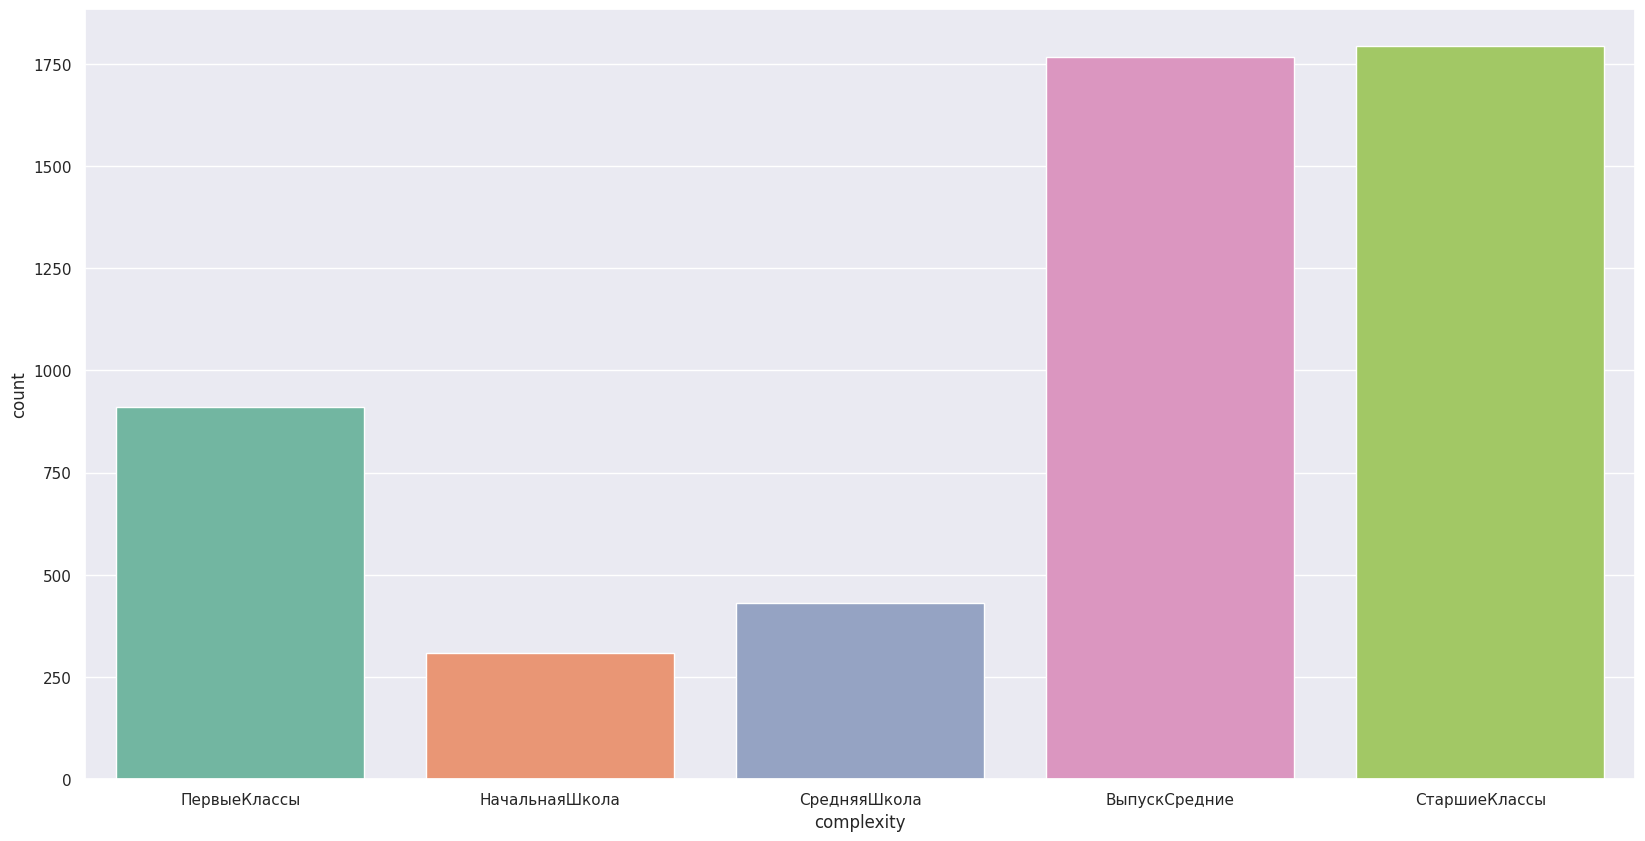

In [14]:
sns.set(rc={'figure.figsize':(20,10)})
sns_plt = sns.countplot(x='complexity', data = all, palette="Set2")

# Pipeline

In [102]:
from sklearn.model_selection import train_test_split

X = all['text']
y = all['complexity']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, test_size=0.3)

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([
                ('vect', CountVectorizer(analyzer='char')),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=3,C=1e5, solver='saga', 
                                           multi_class='multinomial',
                                           max_iter=1000,
                                           random_state=42)),
])

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

themes = all['complexity'].unique()

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
print(classification_report(y_test, y_pred, target_names = themes))
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")

                precision    recall  f1-score   support

  ПервыеКлассы       0.36      0.49      0.42       482
НачальнаяШкола       0.16      0.03      0.06        87
  СредняяШкола       0.47      0.38      0.42       301
 ВыпускСредние       0.49      0.16      0.25       128
 СтаршиеКлассы       0.55      0.59      0.57       566

      accuracy                           0.45      1564
     macro avg       0.41      0.33      0.34      1564
  weighted avg       0.45      0.45      0.44      1564

F1 Score: 0.43703040287584727


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# catboost 

In [17]:
!pip install catboost 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.9 MB/s eta 0:00:00


In [18]:
import catboost
from catboost import CatBoostClassifier, Pool

def fit_model(train_pool, test_pool, **kwargs):
    model = CatBoostClassifier(task_type='CPU', iterations = 5000,
                               eval_metric='TotalF1', od_type='Iter', 
                               od_wait=500, **kwargs)
    
    return model.fit(train_pool, eval_set=test_pool, 
                     verbose=100, plot=True, 
                     use_best_model=True)

In [19]:
X_train

325     помнить захотеть отыскать клад пойти лес найти...
1051                                  банкнот номинал руб
3209    неискушённый вкладчик который такой умение обл...
3658             это устранить риск изменение курс валюта
4756    проблема следовать искать сфера который разбир...
                              ...                        
466                           вот выглядеть купюра доллар
3092    тогда понимать ждать близкий будущее точка зре...
3772    а протягивать подпись несколько страница мелки...
5191    этот вид портфель иметь цель столько приумноже...
860                                      а копить монетка
Name: text, Length: 3649, dtype: object

In [20]:
train_pool = Pool(data=X_train, label=y_train, text_features = [0])

In [55]:
xe = pd.concat([X_test], ignore_index=True)
ye = pd.concat([y_test], ignore_index=True)

In [57]:
xe

0       [год, такой, образ, человек, способный, предло...
1       [вот, например, какой, оригинальный, коллекция...
2       [путёвка, билет, пропасть, прийтись, вернуться...
3             [кто, поверить, смочь, произвести, продать]
4                                  [это, здание, бумажка]
                              ...                        
1559    [к, выбор, страховой, компания, подходить, отв...
1560    [после, взнос, новичок, должный, пригласить, е...
1561    [для, подать, специальный, заявление, асв, смо...
1562    [совсем, непросто, выстроить, такой, цепочка, ...
1563    [агрессивный, инвестор, составлять, агрессивны...
Name: text, Length: 1564, dtype: object

In [58]:
i=0;
while(i < len(xe)):
    xe[i]= " ".join(xe[i])
    i=i+1

In [49]:
X_test.index[3]

4979

In [60]:
valid_pool = Pool(data = xe, label = ye, text_features = [0])

In [62]:
model = fit_model(train_pool, valid_pool, learning_rate=0.35,
                  dictionaries = [{
                      'dictionary_id':'Word',
                      'max_dictionary_size': '50000'
                  }],
                 feature_calcers = ['BoW:top_tokens_count=10000'])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2078665	test: 0.1648442	best: 0.1648442 (0)	total: 2.88s	remaining: 4h 23s
100:	learn: 0.7012902	test: 0.6173385	best: 0.6173385 (100)	total: 2m 2s	remaining: 1h 38m 48s
200:	learn: 0.7624853	test: 0.6415839	best: 0.6479027 (194)	total: 3m 42s	remaining: 1h 28m 25s
300:	learn: 0.7987790	test: 0.6611360	best: 0.6636151 (280)	total: 5m 21s	remaining: 1h 23m 44s
400:	learn: 0.8276567	test: 0.6691524	best: 0.6697684 (399)	total: 7m 4s	remaining: 1h 21m 4s
500:	learn: 0.8482257	test: 0.6730410	best: 0.6744860 (487)	total: 8m 47s	remaining: 1h 18m 52s
600:	learn: 0.8709383	test: 0.6772350	best: 0.6772350 (599)	total: 10m 29s	remaining: 1h 16m 44s
700:	learn: 0.8887622	test: 0.6722057	best: 0.6789613 (628)	total: 12m 12s	remaining: 1h 14m 54s
800:	learn: 0.9049060	test: 0.6725914	best: 0.6789613 (628)	total: 13m 56s	remaining: 1h 13m 6s
900:	learn: 0.9194998	test: 0.6720240	best: 0.6789613 (628)	total: 15m 41s	remaining: 1h 11m 22s
1000:	learn: 0.9321233	test: 0.6687465	best: 0.67

# RandomForestClassifier, LinearSVC(), MultinomialNB(), LogisticRegression

https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb

In [107]:
df['category_id'] = all['complexity'].factorize()[0]
category_id = df[['complexity', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id.values)
id_to_category = dict(category_id[['category_id', 'complexity']].values)

In [125]:
id_to_category

{0: 'ПервыеКлассы',
 1: 'НачальнаяШкола',
 2: 'СредняяШкола',
 3: 'ВыпускСредние',
 4: 'СтаршиеКлассы'}

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

In [ ]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))

features = tfidf.fit_transform(all.text).toarray()
labels = all.complexity

In [123]:
labels

0        ПервыеКлассы
1        ПервыеКлассы
2        ПервыеКлассы
3        ПервыеКлассы
4        ПервыеКлассы
            ...      
5208    СтаршиеКлассы
5209    СтаршиеКлассы
5210    СтаршиеКлассы
5211    СтаршиеКлассы
5212    СтаршиеКлассы
Name: complexity, Length: 5213, dtype: object

In [68]:
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

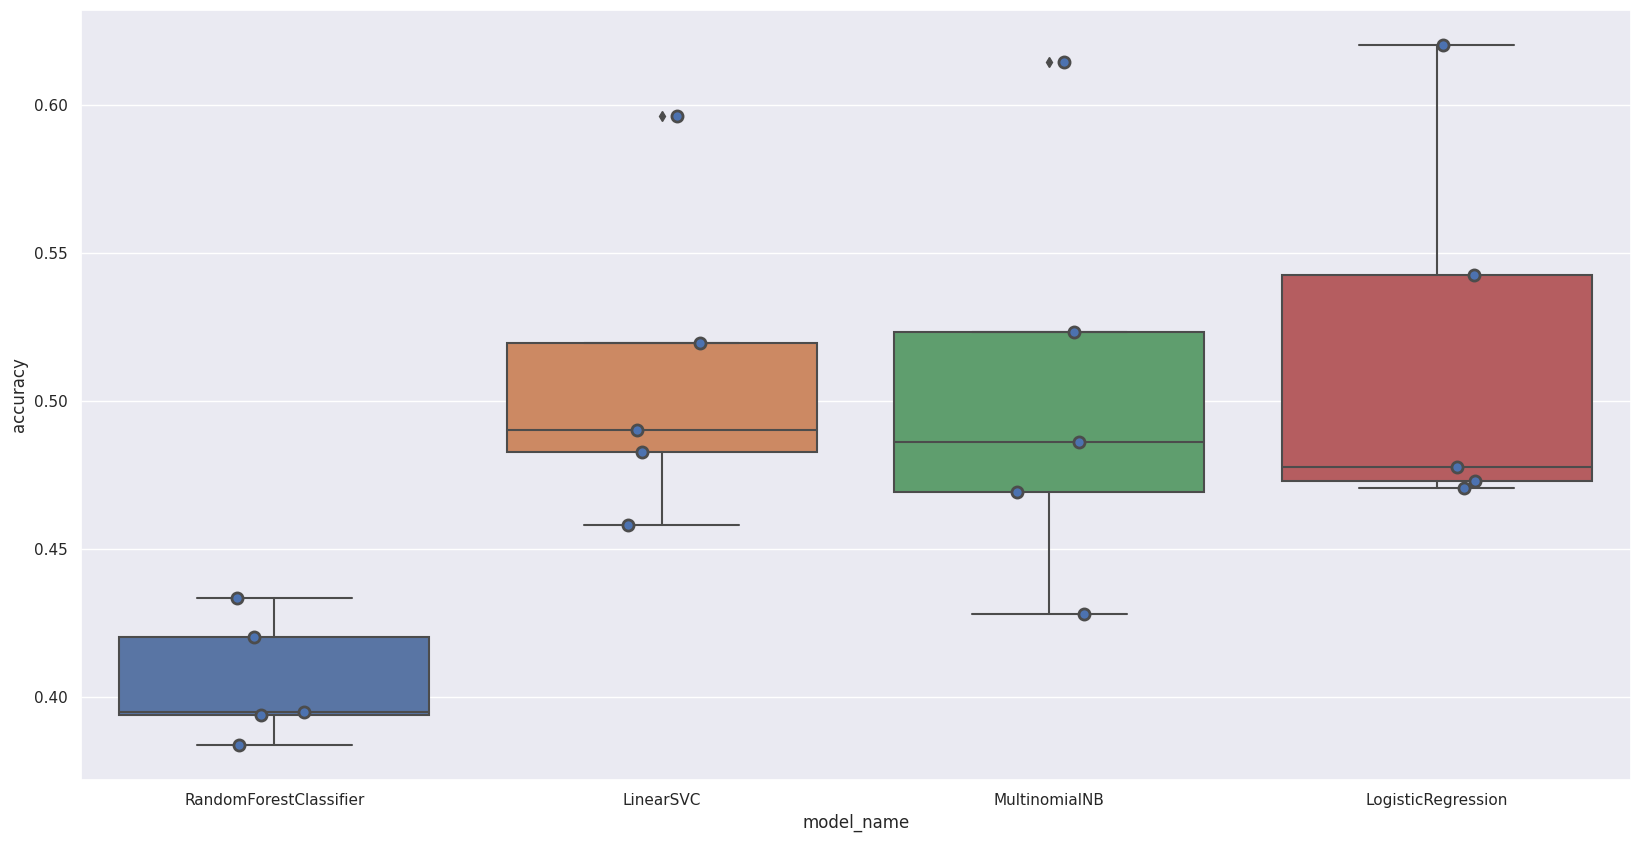

In [69]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [70]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.509487
LogisticRegression        0.516961
MultinomialNB             0.504295
RandomForestClassifier    0.405332
Name: accuracy, dtype: float64

In [138]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, all.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [98]:
y_train

1778    ВыпускСредние
1700    ВыпускСредние
443      ПервыеКлассы
3948    СтаршиеКлассы
2623    ВыпускСредние
            ...      
4931    СтаршиеКлассы
3264    ВыпускСредние
1653    ВыпускСредние
2607    ВыпускСредние
2732    ВыпускСредние
Name: complexity, Length: 3492, dtype: object

In [73]:
df = all

In [137]:
df

,text,complexity,category_id
0,сам слово экономика прийти греческий язык,ПервыеКлассы,0
1,оно состоять два слово экос дом номос закон пе...,ПервыеКлассы,0
2,экономика это хозяйственный деятельность человек,ПервыеКлассы,0
3,как называться место ваш проживание,ПервыеКлассы,0
4,вы жить город село,ПервыеКлассы,0
...,...,...,...
5208,цена консервативный инвестиционный портфель от...,СтаршиеКлассы,4
5209,цена консервативный портфель расти вместе рост...,СтаршиеКлассы,4
5210,ценный бумага выпустить предприятие этот секто...,СтаршиеКлассы,4
5211,управление портфель активный пассивный по уров...,СтаршиеКлассы,4


In [77]:
df['category_id'] = all['complexity'].factorize()[0]
category_id = df[['complexity', 'category_id']].drop_duplicates().sort_values('category_id')

In [83]:
id_to_category = dict(category_id[['category_id', 'complexity']].values)

In [86]:
id_to_category

{0: 'ПервыеКлассы',
 1: 'НачальнаяШкола',
 2: 'СредняяШкола',
 3: 'ВыпускСредние',
 4: 'СтаршиеКлассы'}

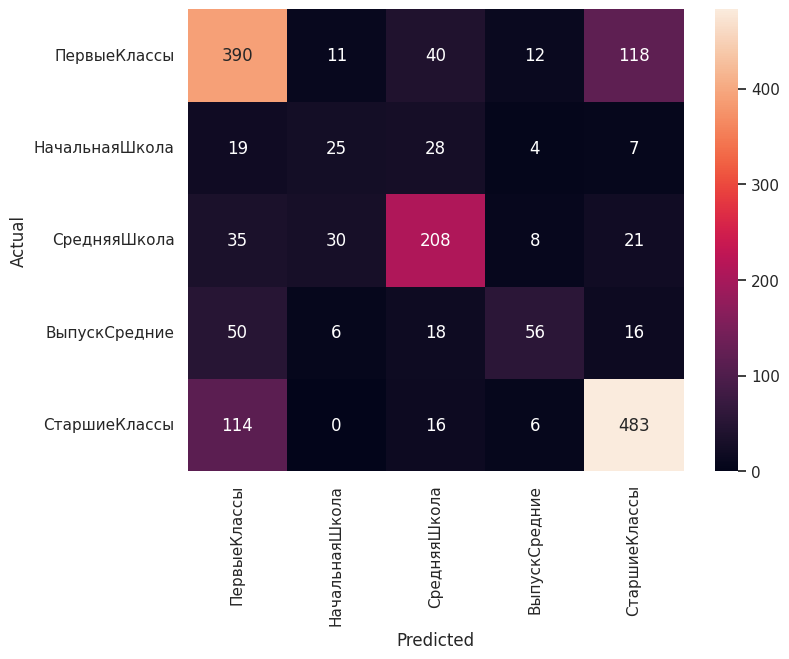

In [80]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id.complexity.values, yticklabels=category_id.complexity.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [81]:
model.fit(features, labels)

LinearSVC()

In [133]:
texts = ['инфляция', 'экономика']
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)

In [134]:
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(category_to_id[predicted]))

"инфляция"
  - Predicted as: '3'
"экономика"
  - Predicted as: '0'


In [139]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['complexity'].unique()))

                precision    recall  f1-score   support

  ПервыеКлассы       0.64      0.68      0.66       571
НачальнаяШкола       0.35      0.30      0.32        83
  СредняяШкола       0.67      0.69      0.68       302
 ВыпускСредние       0.65      0.38      0.48       146
 СтаршиеКлассы       0.75      0.78      0.76       619

      accuracy                           0.68      1721
     macro avg       0.61      0.57      0.58      1721
  weighted avg       0.67      0.68      0.67      1721

